<h2>Photo-z validation metrics on Resampled Alhambra/Cosmos Data</h2>

This notebook shows how to load a .yaml /.p pickle file from all 100 of the resampled Alhambra/Cosmos validation files.

We then determine the error, from the spread of metric values from the 100 RS validation data, and also from the Cosmic Variance analysis.

In [36]:
import yaml
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pickle
import bz2
import bh_photo_z_validation as pval
path = '/Users/hoyleb/Documents/python/modules/photoz-wg/validation/'

#['point_LSS_MLv2.p.bz2', 'point_LSS_TPLv2.p.bz2', 'point_WL_MLv2.p.bz2','point_WL_TPLv2.p.bz2']
#'point_Y1_MLv2.p.bz2','point_Y1_TPLv2.p.bz2']

path_to_pickle_output_file = path + 'point_Y1_TPLv2.p.bz2'

path_to_cos_var_pickle_file = path + 'cosmic_variance_data/cosvariance_cosmos_z_metrics.p.bz2'

In [37]:
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams.update({'font.size': 32, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 22,
                    'ytick.labelsize': 22})

<h3>Metrics of interest</h3>

Let us decide which metrics we want to measure. Edit this list with metrics that we measured from the validation script. Look at the structure of the validation .yaml file to understand this indexing.

In [38]:
#metrics to plot.
#'metric_name': [WHICH_Z_COLUMN, WAY_TO_COMPARE_DISTs, METRIC, [,MEASURED_ON]]
metrics = {'sigma_68': ['MEAN_Z', 'metrics_diffz','bh_photo_z_validation.sigma_68', 'delta_z'],
           'outlier_fraction': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outlier_fraction', 'diff_1pz'],
           'outFrac_2sigma68': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outFrac_2sigma68', 'delta_z'],
           'outFrac_3sigma68': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outFrac_3sigma68', 'delta_z'],
           'median': ['MEAN_Z', 'metrics_diffz', 'numpy.median', 'delta_z'],
           'wl_metric': ['Z_MC', 'metrics_z1_z2', 'bh_photo_z_validation.wl_metric']
           }

#which bining column should we choose?
bin_column = 'MEAN_Z'

#requirements from science handbook
# http://des-docdb.fnal.gov:8080/cgi-bin/RetrieveFile?docid=20&filename=sciReq-9.86.pdf&version=32
# http://des-docdb.fnal.gov:8080/cgi-bin/ShowDocument?docid=1719
requirements = {'sigma_68':{'value': 0.12, 'error': 0.003},
                'wl_metric': {'value': 0.02, 'error': 0.003},
                'outFrac_2sigma68': { 'value': 0.1 , 'error': 0.001 },
                'outFrac_3sigma68': {'value': 0.015, 'error': 0.00015 },
                }

#plotting ranges
plt_range = {'sigma_68': [0, 0.5],
            'wl_metric': [0, 0.1],
            'outFrac_2sigma68': [0, 0.3],
            'outFrac_3sigma68': [0, 0.3],
             'median' : [-0.2, 0.2],
             'outlier_fraction': [0,70]
            }

metric_latex = {
    'sigma_68' :'$\sigma_{68}(z_{true} - z_{pred})$',
    'wl_metric': '$|<dNdz_{true}> - <dNdz_{pred}>|$',
    'outFrac_2sigma68': '$f(>2*\sigma_{68})$',
    'outFrac_3sigma68': '$f(>3*\sigma_{68})$',
    'median' : '$\mu(z_{true} - z_{pred})$',
    'outlier_fraction': '$f(|(z_{true} - z_{pred})/(1+z_{true})|>1.5)$'
}

<h3>Load results files</h3>

Now let's load the .p [pickle] file output from the validation pipeline, and also the cosmic variance results we calculated elsewhere [Ask Youngsoo/Ben/Markus for details].


In [39]:
res = pickle.load(bz2.BZ2File(path_to_pickle_output_file, 'r'))
cosvar = pickle.load(bz2.BZ2File(path_to_cos_var_pickle_file, 'r'))

In [40]:
files = res.keys()
def get_val(dct, ky):
    return dct[ky]

sample = files[0].split('/')[-1].split('ScienceCase')[0].split('_.')[1]

code = 'ML'
if 'bpz' in files[0]:
    code = 'TPL'

print (sample + ' ' + code)

Y1 TPL


In [41]:
#get the error component from the resampled Alhambra data
m_res = {} #temporary value storage
metric_res = {} #this holds the median metric value, and std from the RS samples. Also the binned results
for m in metrics.keys(): 
    met_kys = metrics[m]
    m_res[m] ={'VALUES': [], 'BINS': {}, 'BIN_CENTER': []}
    metric_res[m] = {'VALUES':[], 'BINS': {}}
    for f in files:
        test_name = res[f].keys()[0]
        
        for j, ky in enumerate(met_kys):
            if j ==0:
                dct = get_val(res[f][test_name], ky)
            else:
                dct = get_val(dct, ky)
        
        m_res[m]['VALUES'].append(dct['VALUE'])
        z_bins = dct['bins'][bin_column]['BIN_CENTERS']

        for j, zbn in enumerate(z_bins):
            if j not in m_res[m]['BINS']:
                m_res[m]['BINS'][j] = []
                m_res[m]['BIN_CENTER'].append(zbn)
            m_res[m]['BINS'][j].append(dct['bins'][bin_column]['VALUE'][j])
    
    #get the median value and the error component from the 68% [standard deviation] of the resampled data.
    metric_res[m]['VALUES'] = np.median(m_res[m]['VALUES']), pval.sigma_68(m_res[m]['VALUES'])
    for j, zbn in enumerate(m_res[m]['BIN_CENTER']):
        metric_res[m]['BINS'][zbn] = np.median(m_res[m]['BINS'][j]), pval.sigma_68(m_res[m]['BINS'][j])

<h3>Next add in CosmicVariance error component</h3>

We repeat the above, and additionally calculate the error on each metric from cosmic variance. and from validating on high quality photo-z instead of spec-z

In [42]:
#this will hold the median metric values, RS errors, AND CosVar Errors
sample_var_cosz = {}
sample_var_truez = {}

for m in metrics.keys(): 
    met_kys = metrics[m]


    sample_var_cosz[m] = {'VALUES':[], 'BINS': {}}
    sample_var_truez[m] = {'VALUES':[], 'BINS': {}}
    
    for j in range(len(metric_res[m]['BINS'].keys())):
        sample_var_truez[m]['BINS'][j] = []
        sample_var_cosz[m]['BINS'][j] = []
    
    #loop over all simulated files.
    for f in cosvar:
        for j, ky in enumerate(met_kys):
            if j ==0:
                cos_dct = get_val(f['COSMOS_Z'], ky)
                z_dct = get_val(f['Z'], ky)
            else:
                cos_dct = get_val(cos_dct, ky)
                z_dct = get_val(z_dct, ky)

        #get the value for all unbinned data        
        sample_var_cosz[m]['VALUES'].append(cos_dct['VALUE'])    
        sample_var_truez[m]['VALUES'].append(z_dct['VALUE'])


        for j in range(len(metric_res[m]['BINS'].keys())):
            sample_var_truez[m]['BINS'][j].append(z_dct['bins'][bin_column]['VALUE'][j])
            sample_var_cosz[m]['BINS'][j].append(cos_dct['bins'][bin_column]['VALUE'][j])
    
    #calculate the 68% spread of these metric values
    sample_var_cosz[m]['VALUES']  = pval.sigma_68(sample_var_cosz[m]['VALUES'])
    sample_var_truez[m]['VALUES']  = pval.sigma_68(sample_var_truez[m]['VALUES'])

    for j in range(len(metric_res[m]['BINS'].keys())):
        sample_var_truez[m]['BINS'][j] = pval.sigma_68(sample_var_truez[m]['BINS'][j])
        sample_var_cosz[m]['BINS'][j] = pval.sigma_68(sample_var_cosz[m]['BINS'][j])

<h3>Plot both error components</h3>

Let's add the cosmic variance error in quadrature to the ReSample error, and plot the results for each metric, as a function of the tomographic bins.

TPLY1
metric: | outFrac_2sigma68
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.1307 \pm \bf 0.0028  ( 9.9e-04 \pm 2.6e-03 \pm 1.4e-04) \\ 
metric: | outlier_fraction
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
26.1405 \pm \bf 2.1151  ( 1.1e-01 \pm 2.1e+00 \pm 6.5e-02) \\ 
metric: | median
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
-0.0271 \pm \bf 0.0078  ( 5.1e-04 \pm 7.8e-03 \pm 9.2e-05) \\ 
metric: | sigma_68
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.2146 \pm \bf 0.0098  ( 9.2e-04 \pm 9.8e-03 \pm 2.5e-04) \\ 
metric: | wl_metric
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.0214 \pm \bf 0.0115  ( 2.2e-03 \pm 1.1e-02 \pm 1.8e-04) \\ 
metric: | outFrac_3sigma68
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.0680 \pm \bf 0.0025  ( 7.7e-04 \pm 2.4e-03 \pm 1.6e-04) \\ 


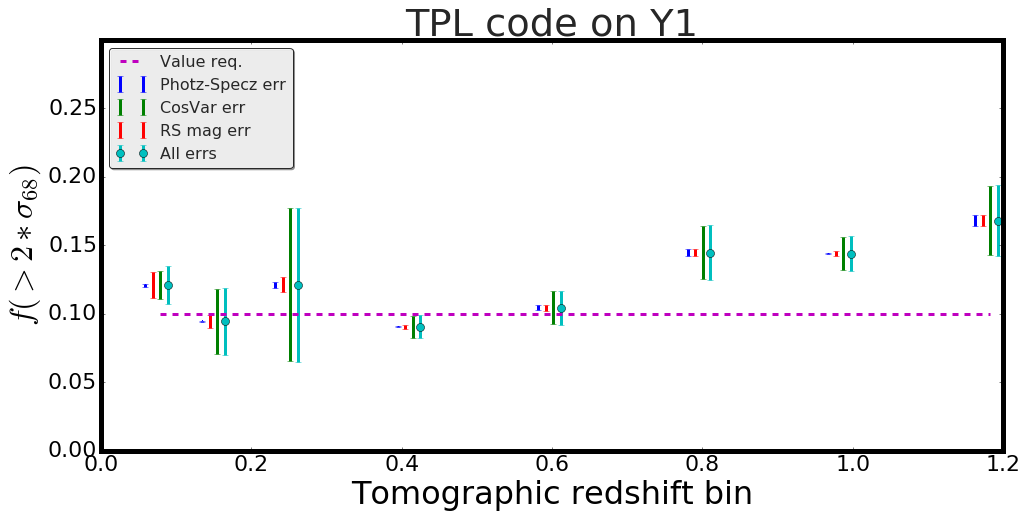

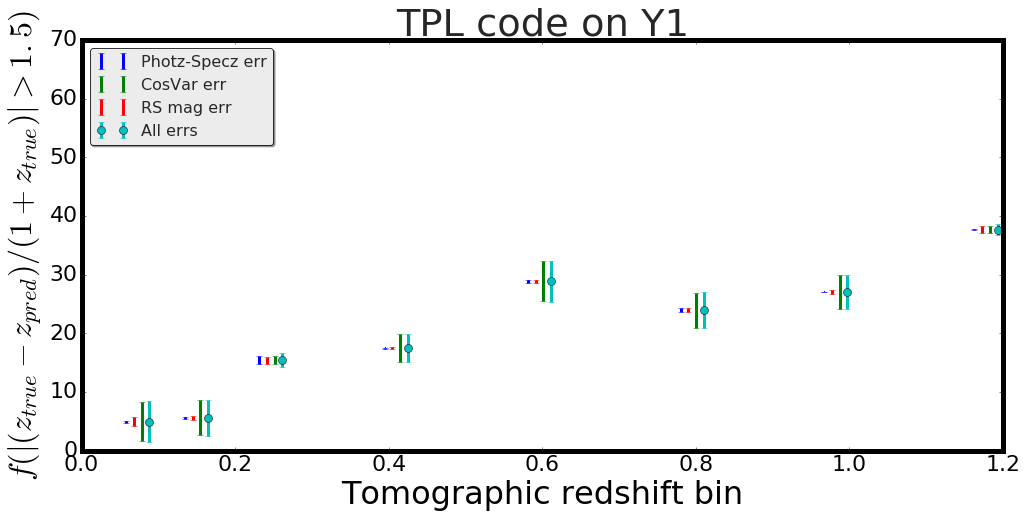

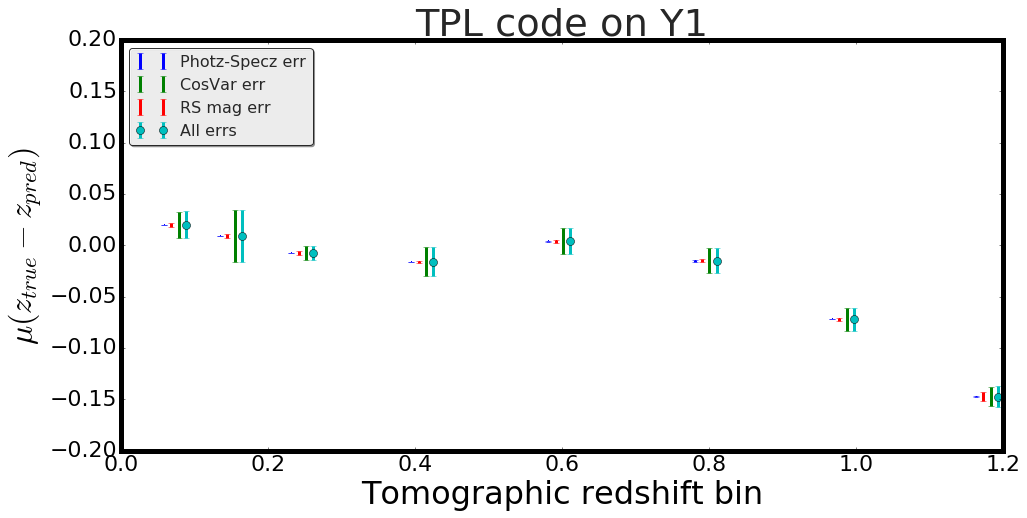

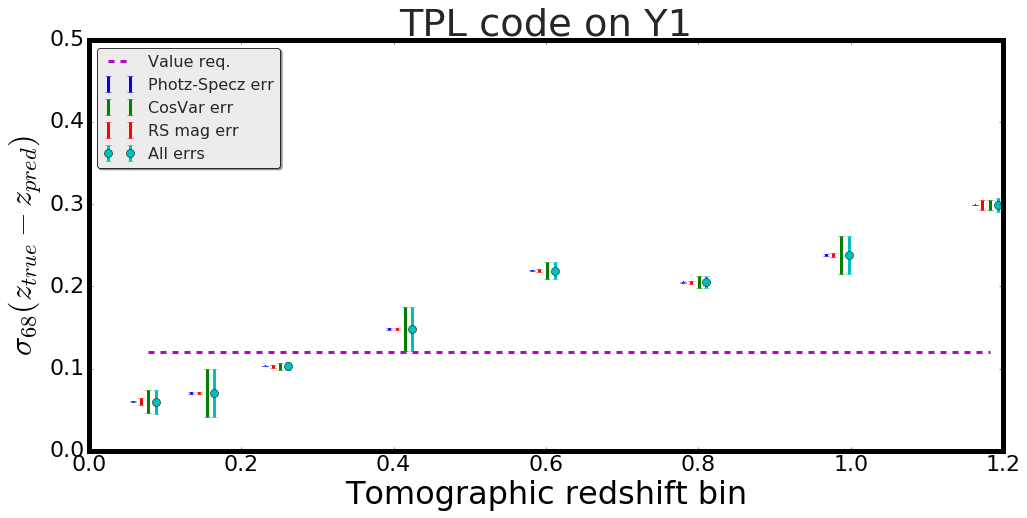

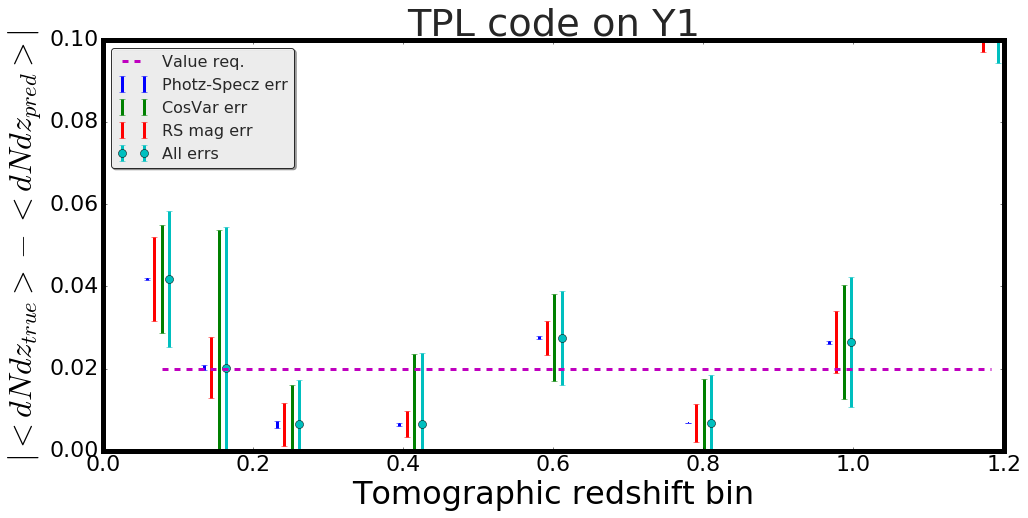

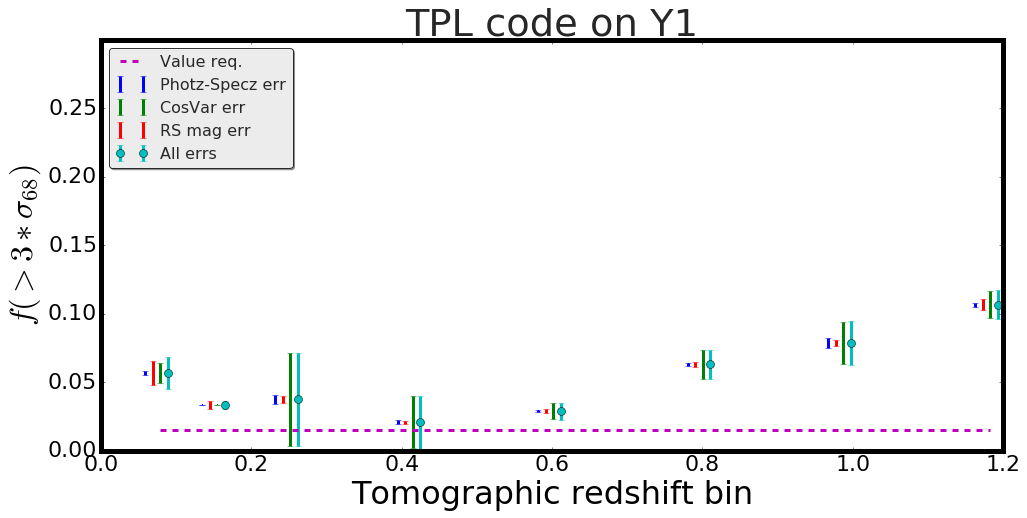

In [43]:
Ms = 8
lw = 3
print (code + sample)
for m in metric_res:
    f= plt.figure()
    z = metric_res[m]['BINS'].keys()
    errRS = np.array([metric_res[m]['BINS'][j][1] for j in z]) #err from ReSample
    errCV =  np.array([sample_var_cosz[m]['BINS'][j] for j in range(len(z))]) #err from CosVar to photo-z
    errNonSpecZ =  np.array([np.abs(sample_var_cosz[m]['BINS'][j] - sample_var_truez[m]['BINS'][j]) 
                             for j in range(len(z))]) #err from COSMOS photo-z to true-z
    
    err = np.sqrt(errRS**2 + errCV**2 + errNonSpecZ**2) #add in quadrature
    y = [metric_res[m]['BINS'][j][0] for j in z]
    plt.errorbar(np.array(z)-0.02, y, yerr=errNonSpecZ, fmt=',', markersize=str(Ms), elinewidth=lw,label='Photz-Specz err')
    plt.errorbar(np.array(z), y, yerr=errCV , fmt=',',markersize=str(Ms), elinewidth=lw, label='CosVar err')
    plt.errorbar(np.array(z)-0.01, y, yerr=errRS, fmt=',', markersize=str(Ms), elinewidth=lw,label='RS mag err')
    plt.errorbar(np.array(z)+0.01, y, yerr=err, fmt='o',markersize=str(Ms), elinewidth=lw, label='All errs')
    
    #get requirements:
    if m in requirements:
        #err_req = [requirements[m]['error']]*len(y)
        #plt.errorbar(np.array(z)+0.01, y, yerr=err, fmt='*',markersize=str(Ms), elinewidth=lw, label='Error req.')
        
        val_req = [requirements[m]['value']]*len(z)
        plt.plot(np.array(np.sort(z)), val_req,'--', linewidth=3,label='Value req.')
    
    plt.xlabel('Tomographic redshift bin')
    plt.title(code + ' code on ' + sample)
    plt.ylim(plt_range[m])
    plt.ylabel(metric_latex[m])
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig('ALH' + code + sample + m + '.pdf')
    
    
    print ('metric: | {:}'.format(m))
    mean = metric_res[m]['VALUES'][0]
    rsErr = metric_res[m]['VALUES'][1]
    cosVarErr = sample_var_cosz[m]['VALUES']
    photSpecErr = np.abs(sample_var_cosz[m]['VALUES'] - sample_var_truez[m]['VALUES'])
    err = np.sqrt(rsErr**2 + cosVarErr**2 + photSpecErr**2)
    print ('Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\\\')
    print ('{:0.4f} \pm \\bf {:0.4f}  ( {:0.1e} \pm {:0.1e} \pm {:0.1e}) \\\\ '.format(mean,err, rsErr, cosVarErr, photSpecErr))

<h3>Generating the sample (cosmic) variance</h3>

This code snippet loads in a heap of validation script outputs, measured on each patch in a simulation, and stores the resulting list in the cosmic variance file in the validation directory.

In [44]:
files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/*.Cosmos*.p')
res = []
for fil in files:
    r = pickle.load(open(fil, 'r'))
    res.append(r)
print len(res)
pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics.p.bz2', 'w'))

434
